In [2]:
%matplotlib inline
import numpy as np
from attention import *
#import pop
#from models import CueAlone, Naive
from common import *
import scipy.stats as sps
from IPython.display import Image
import matplotlib.pyplot as plt

In [ ]:
# %load test_models.py
#Probes for the test of model classes

#CUE ALONE

from models import CueAlone
import numpy as np

class SimData(object):
    def __init__(self,nt,l):        
        self.N_events = nt
        self.N_units = 1
        self.N_t = nt#number of trials
        self.L = l# length of one trial
        self.event_t_msec = np.linspace(0,l,l)
        #Stimuli?
        self.S__ts =np.random.random_integers(0,1,[nt,1])
        
        self.m_gain = 0.4
        self.C = self.S__ts
        
        self.D = sps.norm.pdf(np.linspace(-2,2,l*nt), 0, 0.1)
        self.D = np.reshape(self.D,[nt,l])
        
        self.M = np.cos(np.linspace(-2*np.pi,2*np.pi,nt))*1
        self.M = np.reshape(self.M,[nt,1])
        
        self.a =self.m_gain* np.exp(self.C)#
        self.Y__tn = np.random.poisson(self.a,[nt,l])
        
        self.is_trial_cue_L = np.random.random_integers(0,1,[1,self.N_t])
        self.is_trial_cue_R =np.array(self.is_trial_cue_L!=1,dtype =float)
        
    def __copy__( self ):
        """ Return a copy of self. """
        #t = self.__class__( self.prefix, empty_copy=True )
        t.__dict__ = self.__dict__.copy()
        return t
    
    
# Simulation
v = SimData(1000,2)
m = CueAlone(v,verbose= True)
m.C__sn

In [ ]:
m.plot_cache_graph(filename = 'plotit.png')
#Image("plotit.png")
m.C__sn.T.flatten()


In [9]:
# Solve for the cue without model interfaces

#Generate data
l =1000 #length of one trial (time)
t = 1000 #trials
n = 2 #n of neurons
# Cue_R  - which side is the monkey cued to attend 
# (0 - ipsilateral, 1-contralateral(corresponding to the hemishare))

X__ti = np.zeros([t,2]) # similar to S__ts in Neil's code
X__ti[:,0] = np.random.random_integers(0,1,[1,t])
X__ti[:,1] = np.float32(X__ti[:,0]!=1)

# two simulated modulators 
wave = (np.cos(np.linspace(-3,3,t)*20))+2 
wave2 = (np.cos(np.linspace(-3,3,t)*1)*10)+20

#cue weights
x1 = X__ti[:,1]
w1 = np.array([1,1])
C1 = x1[:,np.newaxis].dot(w1[:,np.newaxis].T)
x2 = X__ti[:,1]
w2 = np.array([0.5,0])
C2 = x2[:,np.newaxis].dot(w2[:,np.newaxis].T)

#slow modulator 
d = np.array([0.05,0.01])
D = wave2[:,np.newaxis].dot(d[:,np.newaxis].T)

#fast modulator weights

v = np.array([0.5,0.5])
M = wave[:,np.newaxis].dot(v[:,np.newaxis].T)


#firing rate 
fr = np.array([0.1,0.1])

#Simulated signal
#Y__tn = np.random.poisson(fr*(np.exp(C1+C2+D+M)),[t,u])
Y__tn = np.random.poisson(fr*(np.exp(C1+C2)),[t,n])


#objective
#objectvie =
#jacobian = 
#hessian = 
#initial values
Y__tn = Y__tn.T
# guess for the cue weigths
Nu__sn = ( Y__tn.dot(X__ti) / X__ti.sum(axis=0)[None, :] ).T    
Nu__sn[ Nu__sn < 0.01 ] = 0.01
#nonlineariy - exp
C__sn = log( Nu__sn ) 


In [10]:
np.shape(X__ti)
np.shape(Y__tn)

(2, 1000)

In [11]:
# %load models.py
from helpers import *
import helpers

np.seterr(all='ignore')

class CueFit( AutoCR ):

    S = 2

    def __init__( self, X,Y, eps_per_obs=1e-5, max_newton_steps=10, nonlinearity='exp',
            solve=True, verbose=True ):
        self.Y__tn = Y
        self.eps_per_obs = eps_per_obs
        self.max_newton_steps = max_newton_steps

        self.T = np.shape(Y)[0]
        self.N = np.shape(Y)[1]
        # parse nonlinearity
        self.nonlinearity = nonlinearity
        if nonlinearity not in ['soft', 'exp']:
            self._raise_nonlinearity_error( nonlinearity )
        self.X = X
        # initialise and solve
        self.initialise( X,Y )
        if solve:
            self.solve( verbose=verbose )
            
    def _raise_nonlinearity_error( self ):
        err_str = "`nonlinearity` is '%s'; must be 'soft' or 'exp'"
        raise ValueError(err_str % self.nonlinearity)

    @cached
    def eps( eps_per_obs, T, N ):
        return eps_per_obs * T * N

    def initialise( self,X,Y ):
        # extract 
        Y__tn = self.Y__tn
        T, N = np.shape(Y)
        # which trial is which 
        S__ts = X
        # inital guess for stimulus-driven component
        Nu__sn = ( Y__tn.T.dot(S__ts) / S__ts.sum(axis=0)[None, :] ).T
        Nu__sn[ Nu__sn < 0.01 ] = 0.01
        # save
        if self.nonlinearity == 'exp':
            self.C__sn = log( Nu__sn )
        elif self.nonlinearity == 'soft':
            tracer()
        self.S__ts = S__ts

    """ For a single neuron """

    @cached
    def a__s( z_vec, S ):
        return z_vec[-S:]

    @cached
    def y__t( Y__tn, n ):
        #Single neuron 
        return Y__tn[ :, n ]

    @cached
    def nu__t( S__ts, a__s ):
        #
        return exp( S__ts.dot(a__s) )

    @cached
    def mu__t( nu__t ):
        return nu__t 

    @cached
    def log_mu__t( mu__t ):
        return log( mu__t )

    @cached
    def r__t( y__t, mu__t ):
        r__t = y__t - mu__t
        r__t[ ~np.isfinite(r__t) ] = 0
        return r__t

    """ Objective for neuron n: h(nu) """

    @cached
    def h( mu__t, y__t, log_mu__t ):
        return np.nansum( mu__t - y__t * log_mu__t )

    """ Jacobian: h'(z, nu) """

    @cached
    def dh( r__t, S__ts ):
        # partials
        da = -r__t.dot( S__ts )
        # put together
        return da

    @cached
    def d2h( mu__t, S__ts ):
        # partials
        da2 = diag( mu__t.dot( S__ts ) )
        return da2

    def solve( self, verbose=True ):
        # construct objective
        objective = self.cfunction( np.array_equal, 'h', 'z_vec' )
        jacobian = self.cfunction( np.array_equal, 'dh', 'z_vec' )
        hessian = self.cfunction( np.array_equal, 'd2h', 'z_vec' )
        # starting values
        last_C__sn = self.C__sn
        C__sn = last_C__sn.copy()
        # run through each cell
        N= self.N
        S = self.S
        for n in progress.dots( range(N), 'solving for Z', verbose=verbose ):
            self.n = n
            self.z_vec = C__sn[:, n]
            z_vec = fmin_ncg( objective, self.z_vec, jacobian, fhess=hessian,
                        disp=True, avextol=1e-3 )
            C__sn[ :, n ] = z_vec[-S:]
        # save
        self.C__sn = C__sn

    """ Calculations: overall """

    @cached
    def Mu__tn( C__sn, S__ts ):
        return np.exp( S__ts.dot(C__sn) )

    @cached
    def log_Mu__tn( Mu__tn ):
        return log( Mu__tn )
    
    @cached
    def LL_per_obs( Mu__tn, log_Mu__tn, Y__tn ):
        return np.nansum( -Mu__tn + Y__tn * log_Mu__tn )

In [12]:
#Y__tn_training = Y__tn[:,0:9000]
#Y__tn_test = Y__tn[:,9000:]
#X__ti_training = X__ti[0:9000]
#X__ti_test = X__ti[9000:]
modelCue  = CueFit(X__ti,Y__tn.T)

solving for ZOptimization terminated successfully.
         Current function value: 586.036552
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 1
.Optimization terminated successfully.
         Current function value: 475.047689
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 1
o[0s]


In [13]:
modelCue._cache_summary
modelCue.C__sn
print(np.shape(Y__tn))
print(modelCue.C__sn)
C__sn = modelCue.C__sn

#C__sn = np.array([w1, w2])
# Compute Predictive LL like Neil specified it
Mu__tn = np.exp( X__ti_test.dot(C__sn) )
log_Mu__tn = log( Mu__tn ) 
pLL = np.nansum( -Mu__tn +Y__tn_test.T * log_Mu__tn ) 
print('PredictiveLL'),
print(pLL)
print('Cue wieghts'),
print(C__sn)
print(modelCue.LL_per_obs)

     a__s      : (2,) array
     d2h       : (2, 2) array
     dh        : (2,) array
     h         : 475.047688883
     log_mu__t : (1000,) array
     mu__t     : (1000,) array
     nu__t     : (1000,) array
     r__t      : (1000,) array
     y__t      : (1000,) array
(2, 1000)
[[-2.18707221 -2.45673577]
 [-0.80946071 -1.24397814]]


NameError: name 'X__ti_test' is not defined

In [ ]:
y  = np.exp(X__ti_test.dot(C__sn))

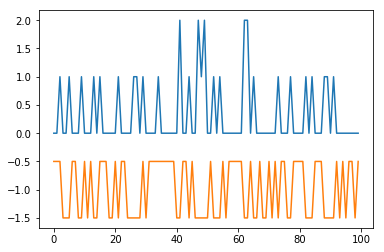

In [14]:
plt.plot(Y__tn[0,0:100])
plt.plot(X__ti[0:100,0]-1.5)
#plt.plot(C1)

In [15]:
from helpers import *
%matplotlib inline
import numpy as np
from attention import *
#import pop
#from models import CueAlone, Naive
from common import *
import scipy.stats as sps
from IPython.display import Image
import matplotlib.pyplot as plt
import attention
reload(attention)
from attention import *
import pop
reload(pop)
reload(mop)
from A2_fit_CG import PopData, PopSolver


#t_ms = d2.event_t_msec
#min_dt = float( np.diff( t_ms ).min() )
#t_idx = np.floor( (t_ms - t_ms.min()) / min_dt ).astype(int)

# regression: initial conditions
#K__i = m.C__sn.T.flatten()
K__i = C__sn
#K__i[ ~np.isfinite(K__i) ] = -3
# initial weights
w__n = np.ones( [n])#w__n = np.ones( d.N_units )
# remove any dodgy cells
# construct model data
#model_data = PopData( X__ti, Y__tn )
model_data = PopData( X__ti,Y__tn.T)#np.random.poisson(1,[100,1]), np.random.poisson(1,[100,2]))
# build model
initial_conditions = { 'k': K__i, 'theta_s':[-7, 10], 's':np.zeros(100), 'w':w__n }
model = PopSolver( model_data, initial_conditions=initial_conditions, rank=1 )
model._grid_search_theta_s_parameters['bounds'] = [[-9, -4], [-40, 20]]
model._bounds_s = [(-9, -4), (-60, 40)]

model.calc_posterior_k()

#        
model.solve( verbose=1 )
#extract the global drift signal
SG__tn = model.posterior_sw.H__sw[ model.training_idxs, : ]
w__n = np.abs( svd( SG__tn - SG__tn.mean(axis=0)[na, :], full_matrices=False )[2][0, :].T )
N_sig = (w__n > (w__n.max() / 10)).sum()

[solve]: (0/12) initial estimate of s, w
[solve]: (2/12) initial re-estimate of s, w
[solve]: (3/12) estimating theta_s, s
[solve]: (4/12) estimating theta_w, w
[solve]: (5/12) estimating theta_s, s
[solve]: (6/12) estimating theta_w, w
[solve]: (7/12) estimating s & w jointly
[solve]: (8/12) estimating theta_k, k
[solve]: (11/12) estimating s & w jointly


In [ ]:
# params:
# k 
# s 
# w - supposed to be wieghts 

In [26]:
np.shape(SG__tn)

(1000, 2)

In [ ]:
model.__dict__.keys()

In [ ]:
model._cache_summary

In [ ]:
plt.plot( model.abs_freqs_s  )
#plt.plot( model.H__sw )

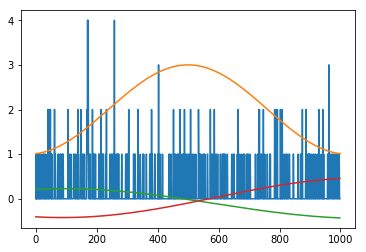

In [27]:
#plt.plot(X__ti.T[1:1000])
plt.figure(0)
plt.plot(Y__tn.T[1:t,0])
plt.plot(wave2.T[:]*0.1)
plt.plot(SG__tn[1:t,:]*10)

#plt.figure(1)

#plt.plot(Y__tn.T[0:t,1])
#plt.plot(wave.T[0:n:n/t])
#plt.plot(X__ti[0:t,0]-1)
#plt.plot(X__ti[0:t,1]-2)

In [ ]:
np.shape(x)

In [29]:
reload(mop)
# group together responses to a single trial
# assemble spike counts
#n =1000
#u = 1
#X__ti = np.random.random_integers(0,1,[100,1])
#wave = (np.cos(np.linspace(-3,3,100)*10))+1
#wave2 = (np.cos(np.linspace(-3,3,100)*2)*4)+10
#y__t = np.random.poisson(wave2*wave,[100])
 
#x[1]=-0.99
#Xind = X__ti==1
#np.shape(Xind)
#x = np.reshape(x,[1000,1])
#x[Xind.T]  =1
unit = 0
x = np.zeros([t,3])
x[:,0] =X__ti[:,0]
x[:,1] =X__ti[:,1]
x[:,2] = SG__tn[:,unit]

md = MopData(x, Y__tn[unit,:].T)

#k0 =np.array([0.1])#K__i = np.array([[0.01],[-0.01],[1]])#np.random.normal(0,1,[1])#np.array([0.01])
k0 =np.array([0.1])
k0 = conc([ k0, [0.1] ]) 
k0 = conc([ k0, [1] ]) 

# construct solver
ms = MopSolver( md, initial_conditions={'k':k0, 'theta_h':[-7, 100]} )
ms.solve(verbose = 0)

# MAP estimates
theta_h = ms.posterior_h.theta_h
k = ms.posterior_k.k_vec
SL__n = ms.posterior_h.expected_log_g[ ms.training_idxs ]
#log_FXk = ms.posterior_k.expected_log_FXk[ ms.training_idxs ]

# reconstruct how to put back in to original dataset
#SL__trial = SL__n.copy()
#SL__event = SL__n[ np.unique( d.trial_idxs, return_inverse=True )[1] ]

# final data structure
#results = {
#        'SL__trial':SL__trial, 'SL__event':SL__event, 
#        'k':k, 'theta_h':theta_h, 'ms':ms, 'md':md}


TypeError: super(type, obj): obj must be an instance or subtype of type

In [31]:
MopData(x,Y__tn)

TypeError: super(type, obj): obj must be an instance or subtype of type

In [ ]:
k0 =np.array([0.1])
k = conc([ k0, [1] ]) 
print(k)

In [ ]:
x =SG__tn[:,1] 
x[1]=-0.99
Xind = X__ti==1
np.shape(Xind)
x = np.reshape(x,[1000,1])
x[Xind.T]  =1
print(np.shape(x))

In [ ]:
print(np.shape(Y__tn[0,:].T))
print(np.shape(x))

In [ ]:
plt.plot(x)
#plt.plot(X__ti.T)

In [ ]:

#plt.plot(wave2[1:1000])
#plt.plot(wave[1:1000]-4)
#plt.plot(x[1:1000]-4)
#plt.plot(Y__tn[1,1:1000].T)
#plt.plot(SG__tn[:,0])


#plt.plot(X__ti.T[1:1000])
plt.figure(0)
plt.plot(Y__tn.T[1:t,0])
plt.plot(wave.T[1:n:n/t])
plt.plot(SG__tn[1:t,0])
plt.plot(SL__n)
#plt.figure(1)

#plt.plot(Y__tn.T[0:t,1])
#plt.plot(wave.T[0:n:t])
#plt.plot(X__ti[0:t,0]-1)
#plt.plot(X__ti[0:t,1]-2)

In [ ]:
SL__n

In [ ]:
ms.plot_cache_graph(filename = 'plotit.png')
Image("plotit.png")

In [ ]:
# %load A3_fit_CGL.py
from attention import * 

#### load event data
if not locals().has_key('event_data'):
    event_data = cPickle.load(open('data/event_data.pickle'))

for a in ['CG', 'C']:
    event_data.load_attribute(a)



#### script

if include_SG:
    d.SG__tn = d.CG.SG__tn
# group together responses to a single trial
d2 = d.group_by_trial
# assemble spike counts
y__t = d2.mean_counts_per_event[unit_idx, :]
md = MopData( X__ti, y__t )

k0 =np.array([0.01,0.1,0.43])
if include_SG:
    k0 = conc([ k0, [1] ])
# construct solver
ms = MopSolver( md, initial_conditions={'k':k0, 'theta_h':[-7, 10]} )
ms.solve(verbose = 0)

# MAP estimates
theta_h = ms.posterior_h.theta_h
k = ms.posterior_k.k_vec
SL__n = ms.posterior_h.expected_log_g[ ms.training_idxs ]
#log_FXk = ms.posterior_k.expected_log_FXk[ ms.training_idxs ]

# reconstruct how to put back in to original dataset
SL__trial = SL__n.copy()
SL__event = SL__n[ np.unique( d.trial_idxs, return_inverse=True )[1] ]

# final data structure
results = {
        'SL__trial':SL__trial, 'SL__event':SL__event, 
        'k':k, 'theta_h':theta_h, 'ms':ms, 'md':md}



def fit_CGL( d_idx, check=False ):
    # check
    d = event_data[ d_idx ]
    attr = 'CGL'
    if check:
        return d.can_load_attribute( attr )
    if d.can_load_attribute( attr ):
        print '[already done]'
        return None
    # fit models individually
    results = []
    for i in progress.dots( range(d.N_units), 'fitting SL' ):
        r = fit_SL_to_unit( d, i )
        results.append(r)
        # has it been done already
        if d.can_load_attribute( attr ):
            print '[already done]'
            return None
    # save
    CGL = Bunch( d.CG.copy() )
    CGL['C__sn'] = A([ r['k'][:2] for r in results ]).T
    CGL['SG__tn'] = CGL['SG__tn'] * A([ r['k'][-1] for r in results ])[None, :]
    CGL['SL__tn'] = A([ r['SL__event'] for r in results ]).T
    CGL['theta_h__ni'] = A([ r['theta_h'] for r in results ])
    CGL = BaseModel( CGL )
    setattr( d, attr, CGL )
    d.save_attribute( attr, overwrite=None )

def fit_CL( d_idx, check=False ):
    # check
    d = event_data[ d_idx ]
    attr = 'CL'
    if check:
        return d.can_load_attribute( attr )
    if d.can_load_attribute( attr ):
        print '[already done]'
        return None
    # fit models individually
    results = []
    for i in progress.dots( range(d.N_units), 'fitting SL' ):
        r = fit_SL_to_unit( d, i, include_SG=False )
        results.append(r)
        # has it been done already
        if d.can_load_attribute( attr ):
            print '[already done]'
            return None
    # save
    CL = Bunch( d.C.copy() )
    CL['C__sn'] = A([ r['k'] for r in results ]).T
    CL['SL__tn'] = A([ r['SL__event'] for r in results ]).T
    CL['theta_h__ni'] = A([ r['theta_h'] for r in results ])
    CL = BaseModel( CL )
    setattr( d, attr, CL )
    d.save_attribute( attr, overwrite=None )




In [ ]:
model.W_star

In [ ]:
plt.plot(SG__tn)
#plt.plot(wave)

In [ ]:
np.shape(SG__tn)

In [ ]:

print(shape(model.Y_training))
print(shape(model.training_idxs))
plt.plot(model.posterior_sw.H__sw)

In [ ]:
model.plot_cache_graph(filename = 'plotit.png')
#Image("plotit.png")
SG__tn = model.posterior_sw.H__sw[ model.training_idxs, : ]
w__n = np.abs( svd( SG__tn - SG__tn.mean(axis=0)[na, :], full_matrices=False )[2][0, :].T )
N_sig = (w__n > (w__n.max() / 10)).sum()

In [ ]:
model.plot_cache_graph(filename = 'plotit.png')
Image("plotit.png")